In [40]:
# If packages are missing, uncomment the next line
# !pip install pandas numpy scikit-learn matplotlib seaborn joblib shap --quiet


In [ ]:
#Install packages

In [3]:
pip install shap

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#Imports & settings

In [4]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit


from sklearn.datasets import load_breast_cancer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import (
    ConfusionMatrixDisplay, RocCurveDisplay,
    classification_report, accuracy_score,
    precision_recall_fscore_support, roc_auc_score
)

RANDOM_SEED = 42
ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(exist_ok=True)


In [ ]:
#Point to My data file

In [5]:
DATA_PATH = Path(
    r"C:/Users/srava/Downloads/breast+cancer+wisconsin+diagnostic/"
    r"breast+cancer+wisconsin+diagnostic/wdbc_data.json"
)


In [ ]:
#Utility: list of 30 feature names

In [6]:
def wdbc_headers():
    base = [
        "radius", "texture", "perimeter", "area", "smoothness",
        "compactness", "concavity", "concave_points", "symmetry",
        "fractal_dimension",
    ]
    suf = ["_mean", "_se", "_worst"]
    return [f"{b}{s}" for s in suf for b in base]


In [ ]:
#Robust data‑loader

In [7]:
def load_wdbc(path: Path | None = None):
    """
    Returns X (DataFrame of 30 features) and y (0=benign, 1=malignant).
    Handles JSON or .data/.csv files that come with or without headers.
    """
    headers = wdbc_headers()

    if path and path.exists():
        # ---- read file ----
        if path.suffix.lower() == ".json":
            df = pd.read_json(path)
        else:
            df = pd.read_csv(
                path, header=None,
                names=["ID", "Diagnosis"] + headers
            )

        # ---- normalise column names ----
        df.columns = [str(c).strip().lower() for c in df.columns]

        # ---- auto‑detect label column ----
        label_col = None
        for col in df.columns:
            uniq = set(str(v).strip().lower() for v in df[col].unique())
            if uniq.issubset({"m", "b"}):
                label_col = col
                break
        if label_col is None:
            raise ValueError("Could not locate Diagnosis column (M/B)")

        # ---- convert labels to 0 / 1 ----
        df[label_col] = df[label_col].apply(
            lambda v: 1 if str(v).strip().upper() == "M" else 0
        )

        X = df[headers]
        y = df[label_col]
        return X, y

    # ---- fallback to scikit‑learn sample ----
    sk = load_breast_cancer(as_frame=True)
    return sk.data, sk.target


In [ ]:
#Head of the data

In [8]:
X, y = load_wdbc(DATA_PATH)
print("Shape :", X.shape)
print("Any NaNs in y ->", y.isna().sum())
display(y.value_counts())     # should show 0s and 1s (e.g., 357 / 212)
display(X.head())


Shape : (569, 30)
Any NaNs in y -> 0


diagnosis
0    357
1    212
Name: count, dtype: int64

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
#Train / val / test split

In [9]:
def split_data(X, y, test=0.15, val=0.15):
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=test,
                                  random_state=RANDOM_SEED)
    train_idx, test_idx = next(sss1.split(X, y))
    X_train_val, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train_val, y_test = y.iloc[train_idx], y.iloc[test_idx]

    val_rel = val / (1 - test)
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=val_rel,
                                  random_state=RANDOM_SEED)
    tr_idx, val_idx = next(sss2.split(X_train_val, y_train_val))

    return (
        X_train_val.iloc[tr_idx], X_train_val.iloc[val_idx], X_test,
        y_train_val.iloc[tr_idx], y_train_val.iloc[val_idx], y_test
    )

X_tr, X_val, X_te, y_tr, y_val, y_te = split_data(X, y)
print("Train:", X_tr.shape, "| Val:", X_val.shape, "| Test:", X_te.shape)


Train: (397, 30) | Val: (86, 30) | Test: (86, 30)


In [ ]:
#Build preprocessing + model pipeline

In [10]:
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer([
    ("num", Pipeline([("scaler", StandardScaler())]), slice(None))
])

clf = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)

pipe = Pipeline([("pre", preprocessor), ("clf", clf)])


In [ ]:
#Hyper‑parameter tuning (GridSearchCV)

In [11]:
param_grid = {
    "clf__n_estimators": [200, 500],
    "clf__max_depth": [None, 5, 10],
    "clf__min_samples_split": [2, 4],
}

gscv = GridSearchCV(
    pipe, param_grid, cv=5, scoring="roc_auc", n_jobs=-1, verbose=1
)
gscv.fit(X_tr, y_tr)

best_model = gscv.best_estimator_
print("Best params:", gscv.best_params_)
print(f"Validation AUC: {gscv.best_score_:.4f}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 500}
Validation AUC: 0.9870


In [ ]:
#Evaluate on held‑out test set

In [17]:
def report(model, X, y, tag="Test"):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    print(f"\n{tag} Classification Report:")
    print(classification_report(y, y_pred,
                                target_names=["Benign", "Malignant"]))
    acc = accuracy_score(y, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y, y_pred,
                                                       average="binary")
    auc = roc_auc_score(y, y_prob)
    return dict(acc=acc, prec=prec, rec=rec, f1=f1, auc=auc)

metrics = report(best_model, X_te, y_te)
print(metrics)



Test Classification Report:
              precision    recall  f1-score   support

      Benign       0.95      1.00      0.97        54
   Malignant       1.00      0.91      0.95        32

    accuracy                           0.97        86
   macro avg       0.97      0.95      0.96        86
weighted avg       0.97      0.97      0.96        86

{'acc': 0.9651162790697675, 'prec': 1.0, 'rec': 0.90625, 'f1': 0.9508196721311475, 'auc': 0.998263888888889}


In [ ]:
#Visualise confusion matrix & ROC curve

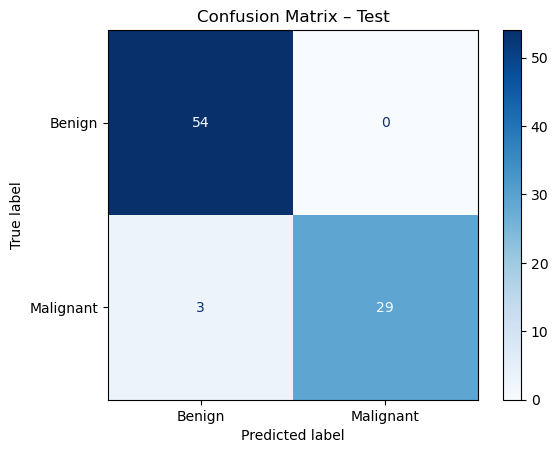

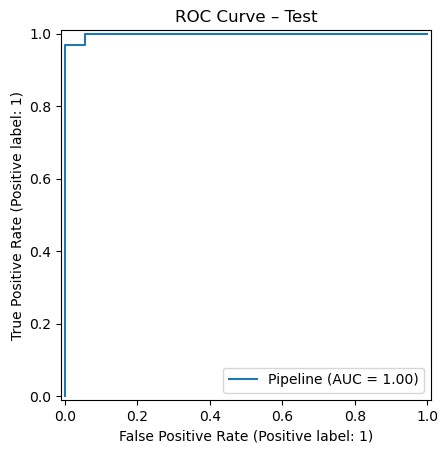

In [12]:
ConfusionMatrixDisplay.from_estimator(
    best_model, X_te, y_te,
    display_labels=["Benign", "Malignant"], cmap="Blues"
)
plt.title("Confusion Matrix – Test")
plt.show()

RocCurveDisplay.from_estimator(best_model, X_te, y_te)
plt.title("ROC Curve – Test")
plt.show()


In [ ]:
#SHAP feature importance

<Figure size 640x480 with 0 Axes>

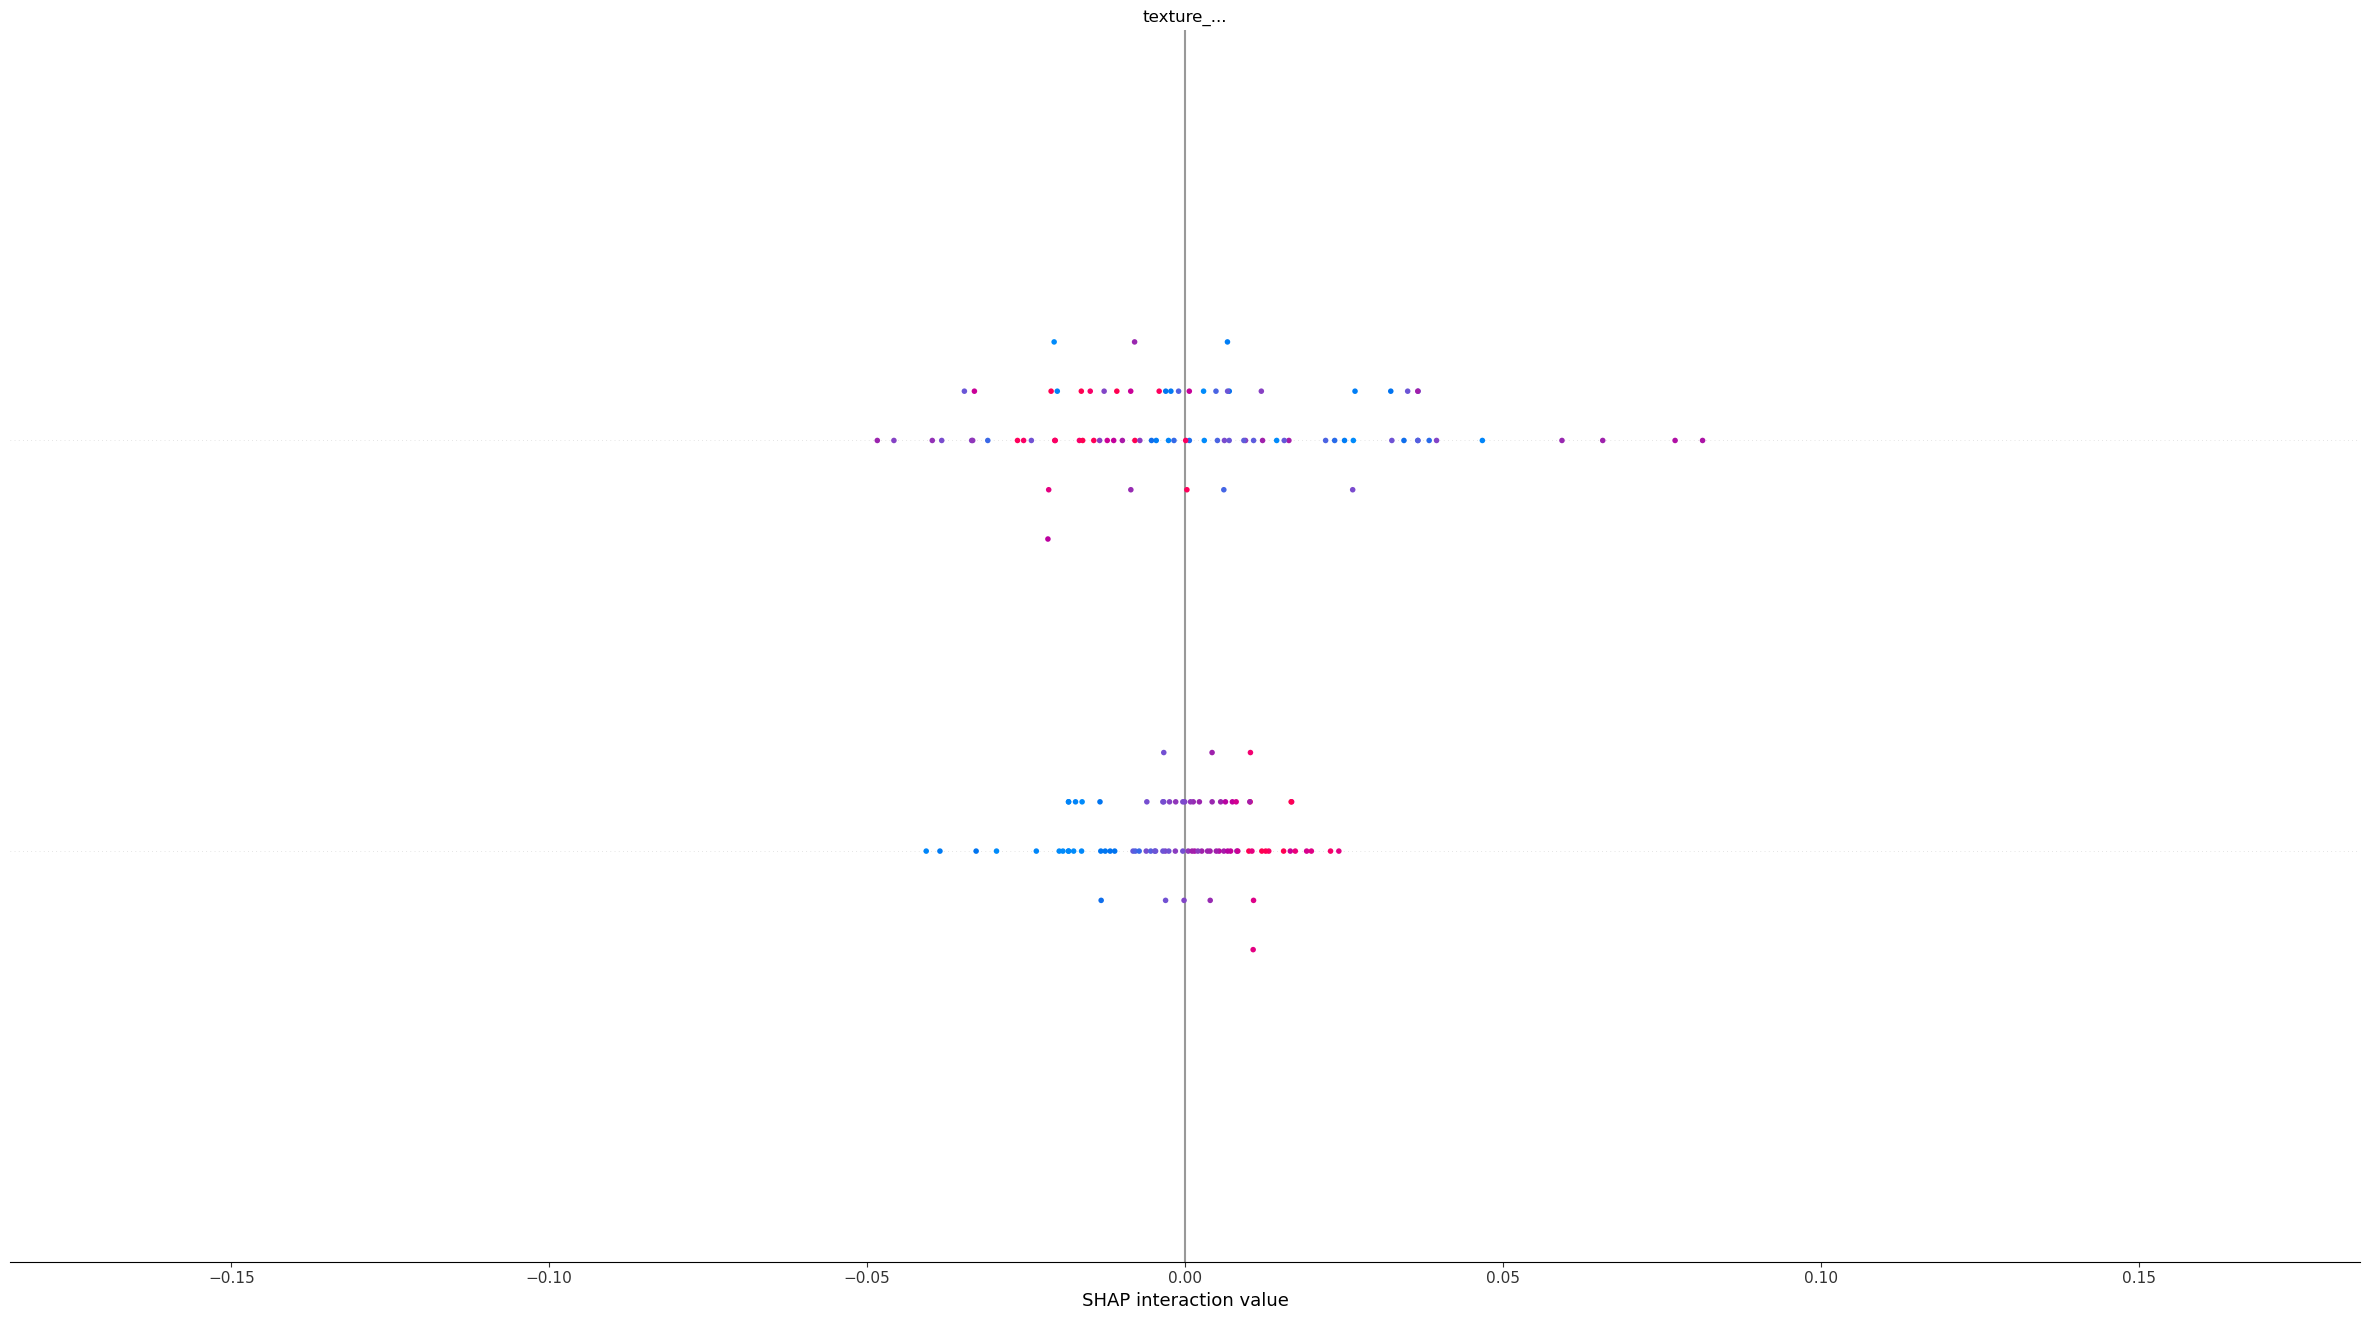

In [14]:
try:
    import shap

    sample_size = min(100, len(X_te))
    sample_data = X_te.sample(sample_size, random_state=RANDOM_SEED)

    explainer = shap.Explainer(best_model.named_steps["clf"])
    shap_values = explainer(
        best_model.named_steps["pre"].transform(sample_data)
    )
    shap.summary_plot(shap_values, sample_data, max_display=15)
except ImportError:
    print("Install SHAP to see feature‑importance plots (pip install shap)")


In [15]:
model_path = ARTIFACTS_DIR / "best_model.joblib"
joblib.dump(best_model, model_path)
print("Model saved to", model_path)


Model saved to artifacts\best_model.joblib


In [16]:
# Example: use first test row
sample = X_te.iloc[0].to_list()
prob = best_model.predict_proba([sample])[0, 1]
pred = "Malignant" if prob >= 0.5 else "Benign"
print(f"Prediction: {pred} (prob={prob:.2%})")


Prediction: Benign (prob=0.40%)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
